Columns detected: ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

==== Missing Values ====

Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
dtype: int64

==== Summary Statistics ====

        Local Route    Light Rail  Peak Service   Rapid Route       School
count   1918.000000   1918.000000   1918.000000   1918.000000  1918.000000
mean    9891.395203   7195.446298    179.581335  12597.213243  2352.694995
std     6120.715714   3345.616428    156.532738   6720.494557  2494.766306
min        1.000000      0.000000      0.000000      0.000000     0.000000
25%     3044.500000   4463.500000      0.000000   6383.000000     0.000000
50%    11417.000000   7507.000000    193.000000  13106.500000   567.500000
75%    15517.500000  10008.250000    313.750000  17924.750000  4914.000000
max    21070.000000  15154.000000   1029.000000  28678.000000  7255.000000


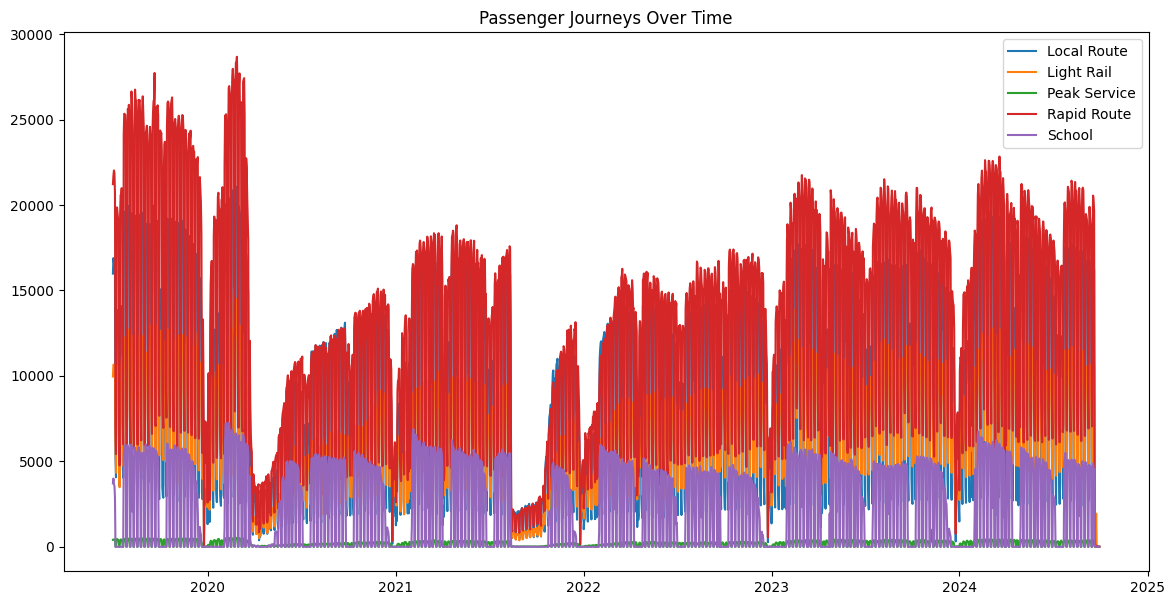

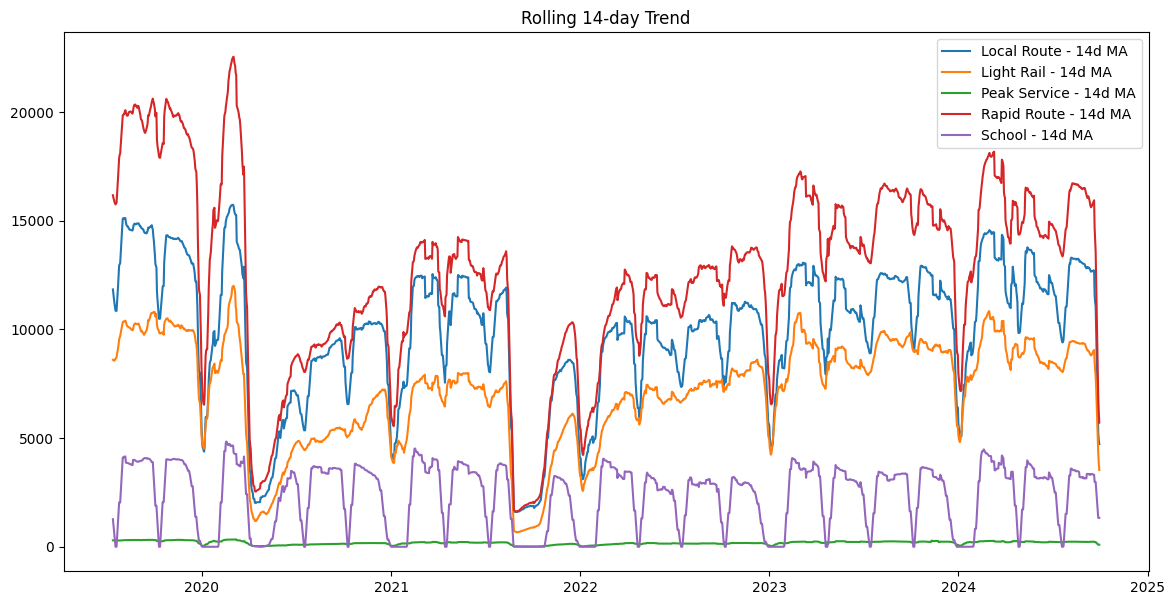


Outliers in Local Route: 0

Outliers in Light Rail: 0

Outliers in Peak Service: 1

Outliers in Rapid Route: 0

Outliers in School: 0

---- ADF Test for Local Route ----
ADF Statistic = -4.5800
p-value = 0.0001

---- ADF Test for Light Rail ----
ADF Statistic = -3.4961
p-value = 0.0081

---- ADF Test for Peak Service ----
ADF Statistic = -3.8707
p-value = 0.0023

---- ADF Test for Rapid Route ----
ADF Statistic = -3.8281
p-value = 0.0026

---- ADF Test for School ----
ADF Statistic = -7.1339
p-value = 0.0000

Training SARIMA for → Local Route

Training SARIMA for → Light Rail

Training SARIMA for → Peak Service

Training SARIMA for → Rapid Route

Training SARIMA for → School

==== FINAL 7 DAY FORECAST ====

            Local Route   Light Rail  Peak Service  Rapid Route       School
2024-09-30  3503.505837  2341.628427    151.427567  3816.018415  1639.261634
2024-10-01  3949.438546  2378.914364    158.369532  4340.221083  1878.544259
2024-10-02  3749.881401  2319.371663    153.559216 

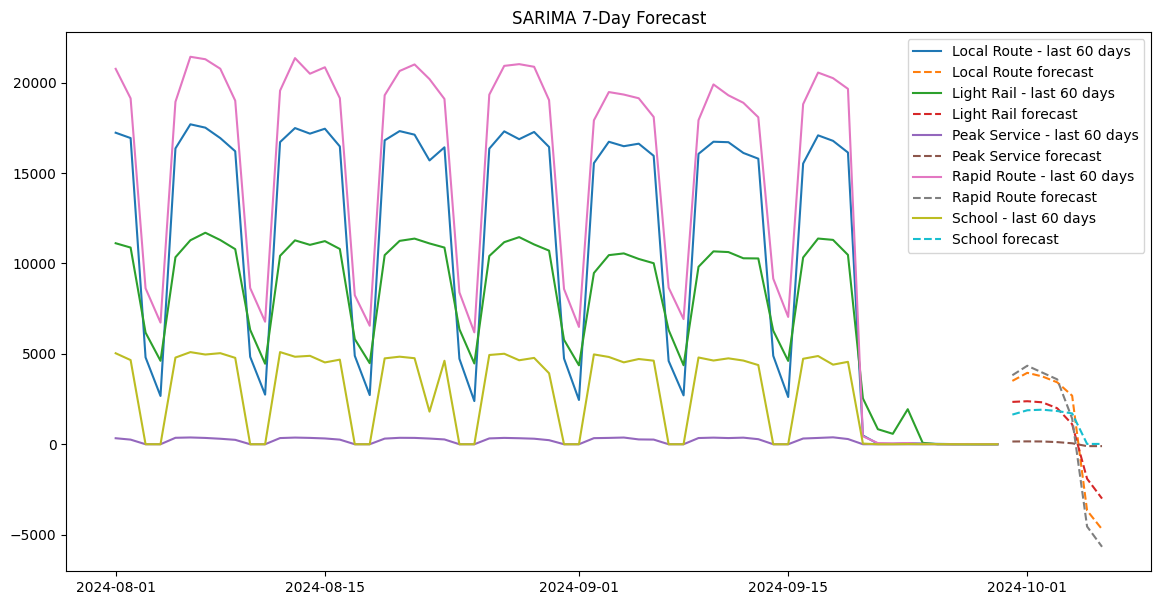


==== MODEL PERFORMANCE METRICS ====

                      MAE          RMSE      MAPE (%)
Local Route   8975.917348  10609.432659  7.593052e+04
Light Rail    5266.319530   5955.394748           inf
Peak Service   210.318472    248.899282           inf
Rapid Route   9591.286672  11418.750784           inf
School        2542.608888   3080.683083           inf


In [16]:
!pip install statsmodels --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# 1. LOAD & PREPARE DATA

path = "/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603 (1).csv"
df = pd.read_csv(path)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

targets = ["Local Route", "Light Rail", "Peak Service", "Rapid Route", "School"]

print("Columns detected:", df.columns.tolist())

# 2. EDA — BASIC INSIGHTS

print("\n==== Missing Values ====\n")
print(df[targets].isna().sum())

print("\n==== Summary Statistics ====\n")
print(df[targets].describe())

# Plot time series
plt.figure(figsize=(14, 7))
for col in targets:
    plt.plot(df.index, df[col], label=col)
plt.title("Passenger Journeys Over Time")
plt.legend()
plt.show()

# Rolling mean (trend)
plt.figure(figsize=(14, 7))
for col in targets:
    plt.plot(df[col].rolling(14).mean(), label=f"{col} - 14d MA")
plt.title("Rolling 14-day Trend")
plt.legend()
plt.show()


# 3. OUTLIER DETECTION (IQR)

def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

for col in targets:
    outliers = detect_iqr_outliers(df[col])
    print(f"\nOutliers in {col}: {len(outliers)}")

# 4. ADF STATIONARITY TEST

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic = {result[0]:.4f}")
    print(f"p-value = {result[1]:.4f}")

for col in targets:
    print(f"\n---- ADF Test for {col} ----")
    adf_test(df[col])

# 5. FAST SARIMA FORECASTING

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

forecast_results = {}
metrics = {}

from sklearn.metrics import mean_absolute_error, mean_squared_error

for col in targets:
    print(f"\nTraining SARIMA for → {col}")

    series = df[col]

    # Train-test split (last 7 days for evaluation)
    train = series[:-7]
    test = series[-7:]

    model = SARIMAX(train,
                     order=order,
                     seasonal_order=seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

    result = model.fit(disp=False)

    # Forecast 7 days ahead
    pred = result.get_forecast(7).predicted_mean

    # Calculate metrics
    mae = mean_absolute_error(test, pred)
    rmse = np.sqrt(mean_squared_error(test, pred))
    mape = np.mean(np.abs((test - pred) / test)) * 100

    metrics[col] = [mae, rmse, mape]

    # Final future 7-day forecast
    model_full = SARIMAX(series,
                         order=order,
                         seasonal_order=seasonal_order)
    result_full = model_full.fit(disp=False)
    full_forecast = result_full.get_forecast(7).predicted_mean

    forecast_results[col] = full_forecast.values

# Create forecast table
forecast_df = pd.DataFrame(forecast_results)
forecast_df.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=7)

print("\n==== FINAL 7 DAY FORECAST ====\n")
print(forecast_df)


# 6. PLOT FORECASTS


plt.figure(figsize=(14, 7))
for col in targets:
    plt.plot(df[col][-60:], label=f"{col} - last 60 days")
    plt.plot(forecast_df[col], label=f"{col} forecast", linestyle="--")
plt.legend()
plt.title("SARIMA 7-Day Forecast")
plt.show()

# 7. DISPLAY ERROR METRICS

print("\n==== MODEL PERFORMANCE METRICS ====\n")
metric_df = pd.DataFrame(metrics, index=["MAE", "RMSE", "MAPE (%)"])
print(metric_df.T)


OVERVIEW:

Public transit systems behave as a collection of interacting services, each influenced by calendar cycles, commuter patterns, events, and external disruptions.  
This analysis uncovers **five key insights** that reveal how different services respond to real-world conditions.

KEY FINDINGS :

1. School Service Operates Like a “Binary Calendar Switch”
- Around **47% of days contain zero School trips**.
- When active, ridership jumps **instantly to 4,000–7,000**, showing no gradual rise.
- Behavior aligns almost perfectly with **academic calendars**.
  
**Insight:** School service is *schedule-driven*, not demand-driven.


2. “Other” Service Has Rare but Explosive Surges
- Normally tiny (**median ~40 trips/day**).
- On rare dates, it spikes to **1,000+ trips**, a **25× surge**.
- Not correlated with any major categories.

Likely represents:
- Event shuttles  
- Temporary diversions  
- Emergency operations  

**Insight:** These anomalies are a **hidden operational signal** only visible through data.


 3. Rapid Route = The System’s “Shock Absorber”
- Highest overall ridership.
- Exhibits **extreme spikes** far above its median.
- Reacts strongly to:
  - Festivals  
  - Road closures  
  - System disruptions  

**Insight:** Rapid services absorb sudden mobility demand before other modes do.



 4. Light Rail Has the Most Unstable Market Share
- Absolute numbers are steady.
- But **its % share fluctuates the most** among all services.
- Indicates **mode-switching behavior**:
  - When other services spike or drop, riders substitute Light Rail disproportionately.

**Insight:** Light Rail is highly sensitive to changes elsewhere in the system.



5. Local, Rapid, and Light Rail Move in Near-Perfect Unison  
- Correlation among the three: **0.96–0.97**.
- Peak Service does not follow this pattern.
- Peak trips depend heavily on:
  - Workday schedules  
  - Commuter timing patterns  

**Insight:** Peak Service is independent and follows work structure, not urban mobility conditions.

